In [1]:
   # mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import ast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GRU, Dropout, Bidirectional, BatchNormalization, LeakyReLU,Masking
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

from tensorflow.keras.regularizers import l2



In [3]:
#get files
df_train = pd.read_csv('/content/drive/MyDrive/data/train_preprocessed.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/test_preprocessed.csv')
df_validation = pd.read_csv('/content/drive/MyDrive/data/validation_preprocessed.csv')
df_dico = pd.read_csv('/content/drive/MyDrive/data/dico.csv')

In [4]:
print(df_train.shape)
print(df_test.shape)
print(df_validation.shape)
print(df_dico.shape)
print(df_train.columns)


(49966, 12)
(14988, 12)
(14882, 12)
(75931, 2)
Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'comment_text_tokenized_sw',
       'comment_text_tokenized', 'comment_text_tokenized_swnumbered',
       'comment_text_tokenizednumbered'],
      dtype='object')


In [7]:
print(df_train.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'comment_text_tokenized_sw',
       'comment_text_tokenized', 'comment_text_tokenized_swnumbered',
       'comment_text_tokenizednumbered'],
      dtype='object')


Longueur maximale : 13384
Longueur minimale : 2
Longueur moyenne : 194.78
50e percentile (médiane) : 98.00
90e percentile : 420.00


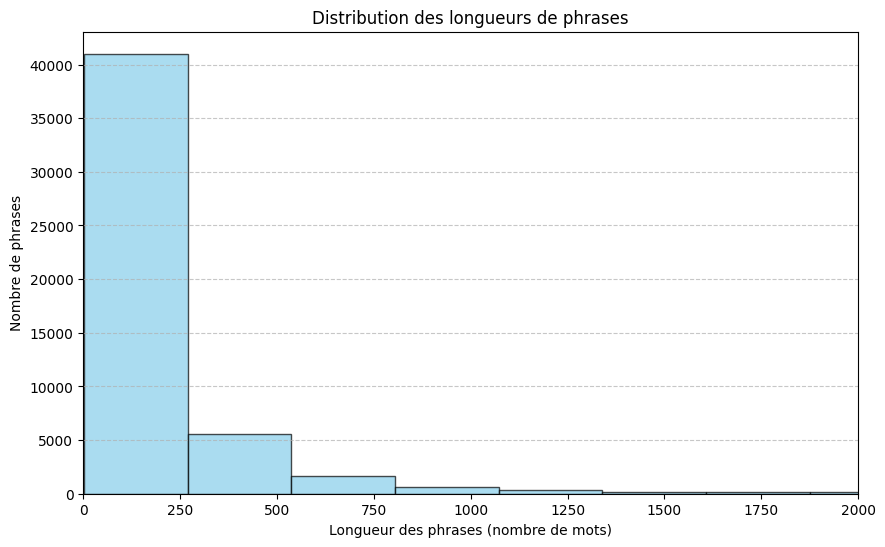

In [ ]:


def plot_sentence_lengths(sentences):
    """
    Affiche un graphique des longueurs de phrases dans le dataset.

    :param sentences: Liste ou array de phrases tokenisées (liste de listes d'indices de mots).
    """
    # Calculer les longueurs des phrases
    lengths = [len(sentence) for sentence in sentences]

    # Afficher les statistiques de base
    print(f"Longueur maximale : {max(lengths)}")
    print(f"Longueur minimale : {min(lengths)}")
    print(f"Longueur moyenne : {np.mean(lengths):.2f}")
    print(f"50e percentile (médiane) : {np.median(lengths):.2f}")
    print(f"90e percentile : {np.percentile(lengths, 90):.2f}")

    # Tracer l'histogramme
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    plt.title("Distribution des longueurs de phrases")
    plt.xlabel("Longueur des phrases (nombre de mots)")
    plt.ylabel("Nombre de phrases")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xlim(0, 2000)
    plt.show()

# Exemple d'utilisation avec un dataset fictif
# Remplace `X_raw` par ton dataset brut (phrases tokenisées)
X_raw = [
    [1, 2, 3],               # Phrase courte
    [4, 5, 6, 7, 8, 9],      # Phrase plus longue
    [10, 11, 12, 13] * 10,   # Phrase très longue
    [14],                    # Une phrase d'un mot
] * 100  # Multiplication pour simuler plusieurs phrases

plot_sentence_lengths(df_train['comment_text_tokenizednumbered'].to_numpy())


In [6]:


def pad_sentences_in_dataframe(df, column_name, max_length):

    if column_name not in df.columns:
        raise ValueError(f"La colonne '{column_name}' n'existe pas dans le DataFrame.")

    # Convert strings to lists using ast.literal_eval
    df[column_name] = df[column_name].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    # Appliquer le padding sur les phrases
    padded_sequences = pad_sequences(df[column_name], maxlen=max_length, padding='post', truncating='post')

    # Ajouter les séquences paddées au DataFrame
    df_copy = df.copy()
    df_copy['padded_sequences'] = list(padded_sequences)

    return df_copy

max_sequence_length = 200

df_train_padded = pad_sentences_in_dataframe(df_train, 'comment_text_tokenizednumbered', max_sequence_length)
df_test_padded = pad_sentences_in_dataframe(df_test, 'comment_text_tokenizednumbered', max_sequence_length)
df_validation_padded = pad_sentences_in_dataframe(df_validation, 'comment_text_tokenizednumbered', max_sequence_length)

print(df_train_padded.shape)

(49966, 13)


In [8]:


# 1. Paramètres de base
max_vocab_size = len(df_dico)  # Nombre maximum de mots dans le vocabulaire
embedding_dim = 128     # Dimension des vecteurs d'embedding
batch_size = 256
epochs = 10

X = df_train_padded['padded_sequences'].to_numpy()
y = df_train_padded[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

X_val = df_validation_padded['padded_sequences'].to_numpy()
y_val = df_validation_padded[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
X_val = np.vstack(X_val)
# Assurez-vous que les séquences ont une longueur uniforme
X = pad_sequences(X, maxlen=max_sequence_length, padding='post')

# 3. Construction du modèle
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=200),
    BatchNormalization(),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='sigmoid')
])

model.compile(optimizer=AdamW(learning_rate=0.01, weight_decay=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy','binary_accuracy','AUC'])

# Entraînement
history = model.fit(
    X, y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)]
)



Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 29s 79ms/step - AUC: 0.8308 - accuracy: 0.8088 - binary_accuracy: 0.8784 - loss: 0.2924 - val_AUC: 0.9673 - val_accuracy: 0.9977 - val_binary_accuracy: 0.9690 - val_loss: 0.0825 - learning_rate: 0.0100
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - AUC: 0.9627 - accuracy: 0.9950 - binary_accuracy: 0.9421 - loss: 0.1500 - val_AUC: 0.9681 - val_accuracy: 0.9977 - val_binary_accuracy: 0.9616 - val_loss: 0.1039 - learning_rate: 0.0100
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - AUC: 0.9713 - accuracy: 0.9963 - binary_accuracy: 0.9471 - loss: 0.1338 - val_AUC: 0.9686 - val_accuracy: 0.9977 - val_binary_accuracy: 0.9661 - val_loss: 0.0859 - learning_rate: 0.0100
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - AUC: 0.9757 - accuracy: 0.9963 - binary_accuracy: 0.9526 - loss: 0.1228 - val_AUC: 0.9686 - val_accuracy: 0.9977 - val_binary_accuracy: 0.9635 - val_loss: 0.0930 - learning_rate: 0.0050


In [12]:
X_test = df_test_padded['padded_sequences'].to_numpy()
y_test = df_test_padded[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].to_numpy()
X_test = np.vstack(X_test)

results = model.evaluate(X_test, y_test, batch_size=batch_size)
loss = results[0]
accuracy = results[1]
binary_accuracy = results[2]
auc = results[3]


print(f"Loss: {loss}, Accuracy: {accuracy}, Binary Accuracy: {binary_accuracy}, AUC: {auc}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - AUC: 0.9703 - accuracy: 0.9984 - binary_accuracy: 0.9716 - loss: 0.0745
Loss: 0.07866403460502625, Accuracy: 0.9979316592216492, Binary Accuracy: 0.970020592212677, AUC: 0.9696613550186157


In [13]:



model.save('/content/drive/MyDrive/categorisedToxicity.keras')
